In [14]:
# test BC (Behavior Cloning)
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class PolicyNet(nn.Module):
    def __init__(
            self,
            state_dim: int,
            action_dim: int,
            hidden_dim: int=128
    ) -> None:
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.fc(x)

# collect expert data
"""
    An episode refers to one full sequence of interactions 
    between an agent and an environment in reinforcement learning
"""
def collect_expert_data(
        env: object,
        expert_policy: object,
        episodes: int=5
) -> object:
    data = []
    for _ in range(episodes):
        state = env.reset()[0]
        done = False
        while not done:
            action = expert_policy(state)
            data.append((state, action))
            """
                openAI Gym env.step(action) Param:
                1.state: new state of the environment after taking action
                2.reward: action reward
                3.done: episodes is Done (bool)
                4.info: a dictionary containing additional information about the environment 
            """
            state, _, done, _, _ = env.step(action)
    return data 

# training
def train_bc(
        policy_net: nn.Module, 
        data: object, 
        epochs: int=5,
        lr: float=1e-3
    ):
    # define optimizer
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    states, actions = zip(*data)
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.long)

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = policy_net(states)
        loss = criterion(outputs, actions)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

# evaluate BC_model performance
def evaluate_policy(env, policy_net, episodes=10):
    success = 0
    for _ in range(episodes):
        state = env.reset()[0]
        done = False
        while not done:
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                action = torch.argmax(policy_net(state_tensor)).item()
            state, _, done, _, _ = env.step(action)
        success += 1
    print(f"Success Rate: {success}/{episodes}")

# define eport policy
def expert_policy(state):
    return 1 if state[2] > 0 else 0

In [15]:
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

expert_data = collect_expert_data(env, expert_policy, episodes=20)

policy_net = PolicyNet(
    state_dim=state_dim,
    action_dim=action_dim
)
train_bc(policy_net, expert_data, epochs=200)
evaluate_policy(env, policy_net)

Epoch 0, Loss: 0.6939858794212341
Epoch 10, Loss: 0.6743330359458923
Epoch 20, Loss: 0.6561333537101746
Epoch 30, Loss: 0.6373411417007446
Epoch 40, Loss: 0.617154598236084
Epoch 50, Loss: 0.5952470898628235
Epoch 60, Loss: 0.5713289976119995
Epoch 70, Loss: 0.5453448295593262
Epoch 80, Loss: 0.517549991607666
Epoch 90, Loss: 0.4889135956764221
Epoch 100, Loss: 0.4601045846939087
Epoch 110, Loss: 0.4315755367279053
Epoch 120, Loss: 0.40371987223625183
Epoch 130, Loss: 0.37671494483947754
Epoch 140, Loss: 0.35152238607406616
Epoch 150, Loss: 0.3289012312889099
Epoch 160, Loss: 0.30868056416511536
Epoch 170, Loss: 0.29051753878593445
Epoch 180, Loss: 0.27415862679481506
Epoch 190, Loss: 0.2598109245300293
Success Rate: 10/10


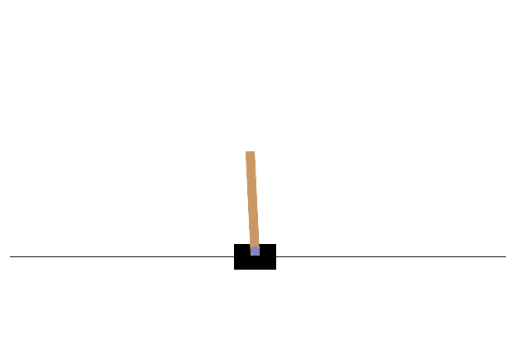

In [2]:
# show the reinforcement environment
import gymnasium as gym
import matplotlib.pyplot as plt

# set environmrnt
env = gym.make("CartPole-v1", render_mode="rgb_array")
state = env.reset()

# get the rendered image
frame = env.render()

# show using matplotlib
plt.imshow(frame)
plt.axis("off")
plt.show()

env.close()

In [ ]:
# use DAgger expert can continue guide agency
# Not Done
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

# 策略网络
class PolicyNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )
    
    def forward(self, x):
        return self.fc(x)

# 采集专家数据
def collect_expert_data(env, expert_policy, episodes=10):
    data = []
    for _ in range(episodes):
        state = env.reset()[0]
        done = False
        while not done:
            action = expert_policy(state)
            data.append((state, action))
            state, _, done, _, _ = env.step(action)
    return data

# 训练 BC（Behavior Cloning）
def train_bc(policy_net, data, epochs=100, lr=1e-3):
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    states, actions = zip(*data)
    states = torch.tensor(np.array(states), dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.long)

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = policy_net(states)
        loss = criterion(outputs, actions)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

# 评估策略
def evaluate_policy(env, policy_net, episodes=10):
    success = 0
    for _ in range(episodes):
        state = env.reset()[0]
        done = False
        while not done:
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                action = torch.argmax(policy_net(state_tensor)).item()
            state, _, done, _, _ = env.step(action)
        success += 1
    print(f"Success Rate: {success}/{episodes}")

# 专家策略
def expert_policy(state):
    return 1 if state[2] > 0 else 0  # 根据杆子的角度选择方向

# **DAgger**
def dagger(env, expert_policy, policy_net, iterations=5, bc_epochs=100):
    expert_data = collect_expert_data(env, expert_policy, episodes=20)
    
    # 先训练初始策略
    train_bc(policy_net, expert_data, epochs=bc_epochs)

    for i in range(iterations):
        new_data = []
        state = env.reset()[0]
        done = False

        while not done:
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                action = torch.argmax(policy_net(state_tensor)).item()
            
            expert_action = expert_policy(state)  # 让专家修正
            new_data.append((state, expert_action))

            state, _, done, _, _ = env.step(action)
        
        # 合并新数据并训练
        expert_data.extend(new_data)
        train_bc(policy_net, expert_data, epochs=bc_epochs)

        print(f"DAgger Iteration {i + 1} Completed")
        evaluate_policy(env, policy_net)

# 运行 DAgger
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

policy_net = PolicyNet(state_dim, action_dim)
dagger(env, expert_policy, policy_net, iterations=5, bc_epochs=100)

# 最终评估
evaluate_policy(env, policy_net)


In [ ]:
# test IRL(Inverse Reinforcement Learning) IRL can inverse deriving the reward function, 
# which can make agency learn expert unknowed
# TODO
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.special import logsumexp


# **1. 收集专家数据**
def collect_expert_data(env, expert_policy, episodes=10):
    trajectories = []
    for _ in range(episodes):
        state = env.reset()[0]
        trajectory = []
        done = False
        while not done:
            action = expert_policy[state]
            trajectory.append((state, action))
            state, _, done, _, _ = env.step(action)
        trajectories.append(trajectory)
    return trajectories

# **2. 最大熵 IRL 计算奖励**
def maxent_irl(trajectories, num_states, num_actions, gamma=0.99, lr=0.1, epochs=100):
    # 计算专家状态访问频率
    state_visitation = np.zeros(num_states)
    for traj in trajectories:
        for (s, _) in traj:
            state_visitation[s] += 1
    state_visitation /= np.sum(state_visitation)

    # 初始化奖励
    rewards = np.random.rand(num_states)

    # 迭代更新奖励
    for epoch in range(epochs):
        # 计算状态值函数 V(s)
        V = np.zeros(num_states)
        for _ in range(100):  # 迭代求解 V(s)
            V = logsumexp(rewards + gamma * np.dot(env.P[:, :, 0], V), axis=1)
        
        # 计算状态-动作值函数 Q(s, a)
        Q = rewards[:, None] + gamma * np.dot(env.P[:, :, 0], V)

        # 计算策略 π(s) = softmax(Q)
        policy = np.exp(Q - logsumexp(Q, axis=1, keepdims=True))

        # 计算模型产生的状态访问频率
        model_visitation = np.zeros(num_states)
        state = env.reset()[0]
        for _ in range(1000):
            action = np.random.choice(num_actions, p=policy[state])
            state, _, done, _, _ = env.step(action)
            model_visitation[state] += 1
            if done:
                state = env.reset()[0]
        model_visitation /= np.sum(model_visitation)

        # 更新奖励
        rewards += lr * (state_visitation - model_visitation)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Reward Update Done")

    return rewards

# **3. 使用 IRL 奖励训练 RL Agent**
class PolicyNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )
    
    def forward(self, x):
        return self.fc(x)

def train_rl(policy_net, rewards, env, lr=1e-2, epochs=500):
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        state = env.reset()[0]
        done = False
        states, actions, returns = [], [], []
        G = 0

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            action_probs = policy_net(state_tensor)
            action = torch.argmax(action_probs).item()

            next_state, reward, done, _, _ = env.step(action)
            G = rewards[state] + 0.99 * G

            states.append(state)
            actions.append(action)
            returns.append(G)

            state = next_state

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long)
        returns = torch.tensor(returns, dtype=torch.float32)

        optimizer.zero_grad()
        outputs = policy_net(states)
        loss = criterion(outputs, actions)
        loss.backward()
        optimizer.step()

        if epoch % 50 == 0:
            print(f"Epoch {epoch}: RL Training Loss {loss.item()}")

# **4. 评估训练的 RL 策略**
def evaluate_policy(env, policy_net, episodes=10):
    success = 0
    for _ in range(episodes):
        state = env.reset()[0]
        done = False
        while not done:
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                action = torch.argmax(policy_net(state_tensor)).item()
            state, reward, done, _, _ = env.step(action)
            success += reward
    print(f"Success Rate: {success}/{episodes}")

# 
env = gym.make("FrozenLake-v1", is_slippery=False)

# 获取状态和动作空间
num_states = env.observation_space.n
num_actions = env.action_space.n

# **运行 IRL**
# 定义专家策略（假设是最短路径策略）
expert_policy = {
    0: 1,  1: 2,  2: 1,  3: 2,
    4: 1,  5: 2,  6: 1,  7: 2,
    8: 1,  9: 2, 10: 1, 11: 2,
    12: 1, 13: 2, 14: 1, 15: 2
}

# 采集专家轨迹
expert_trajectories = collect_expert_data(env, expert_policy, episodes=20)

# 运行最大熵 IRL 获取奖励
irl_rewards = maxent_irl(expert_trajectories, num_states, num_actions)

# 训练 RL Agent
policy_net = PolicyNet(num_states, num_actions)
train_rl(policy_net, irl_rewards, env)

# 评估训练结果
evaluate_policy(env, policy_net)


AttributeError: 'TimeLimit' object has no attribute 'P'

In [ ]:
# test gan （GAIL）
# Directly learn the expert’s policy without explicitly learning a reward function, better than DAgger、
# TODO
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# **1. 创建环境**
env = gym.make("CartPole-v1")
env = DummyVecEnv([lambda: env])

# **2. 训练专家策略**
expert_model = PPO("MlpPolicy", env, verbose=1)
expert_model.learn(total_timesteps=50000)

# **3. 采集专家轨迹**
def collect_expert_data(env, model, episodes=10):
    data = []
    for _ in range(episodes):
        obs = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs)
            data.append((obs, action))
            obs, _, done, _ = env.step(action)
    return data

expert_data = collect_expert_data(env, expert_model, episodes=20)

# **4. 定义 GAIL 判别器**
class Discriminator(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1)
        return self.net(x)

# **5. 训练 GAIL**
def train_gail(env, expert_data, iterations=5000, lr=1e-3):
    state_dim = env.observation_space.shape[0]
    action_dim = 1  # CartPole 的动作是离散的（0 or 1）

    discriminator = Discriminator(state_dim, action_dim)
    optimizer = optim.Adam(discriminator.parameters(), lr=lr)
    criterion = nn.BCELoss()

    agent = PPO("MlpPolicy", env, verbose=0)

    for i in range(iterations):
        # **生成 agent 轨迹**
        agent_data = collect_expert_data(env, agent, episodes=5)

        # **准备训练数据**
        states_expert = torch.tensor(np.array([s for s, _ in expert_data]), dtype=torch.float32)
        actions_expert = torch.tensor(np.array([a for _, a in expert_data]), dtype=torch.float32).unsqueeze(-1)
        labels_expert = torch.ones(len(expert_data), 1)  # Label=1 for expert

        states_agent = torch.tensor(np.array([s for s, _ in agent_data]), dtype=torch.float32)
        actions_agent = torch.tensor(np.array([a for _, a in agent_data]), dtype=torch.float32).unsqueeze(-1)
        labels_agent = torch.zeros(len(agent_data), 1)  # Label=0 for agent

        # **计算判别器损失**
        expert_preds = discriminator(states_expert, actions_expert)
        agent_preds = discriminator(states_agent, actions_agent)

        loss_expert = criterion(expert_preds, labels_expert)
        loss_agent = criterion(agent_preds, labels_agent)
        loss = (loss_expert + loss_agent) / 2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # **训练策略 π 使其最大化 D 误判的概率**
        agent.learn(total_timesteps=1000)

        if i % 100 == 0:
            print(f"Iteration {i}, Discriminator Loss: {loss.item()}")

    return agent

# **6. 运行 GAIL 训练**
trained_agent = train_gail(env, expert_data)

# **7. 评估 GAIL 训练后的策略**
def evaluate_agent(env, model, episodes=10):
    success = 0
    for _ in range(episodes):
        obs = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs)
            obs, reward, done, _ = env.step(action)
            success += reward
    print(f"Average Reward: {success / episodes}")

evaluate_agent(env, trained_agent)